In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_25 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_26 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_27 (Activation)   (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3081 - acc: 0.2699
Epoch 00001: val_loss improved from inf to 1.96079, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_3_conv_checkpoint/001-1.9608.hdf5
36805/36805 [==============================] - 26s 710us/sample - loss: 2.3081 - acc: 0.2700 - val_loss: 1.9608 - val_acc: 0.3864
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7628 - acc: 0.4603
Epoch 00002: val_loss improved from 1.96079 to 1.71499, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_3_conv_checkpoint/002-1.7150.hdf5
36805/36805 [==============================] - 24s 655us/sample - loss: 1.7628 - acc: 0.4603 - val_loss: 1.7150 - val_acc: 0.4701
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5066 - acc: 0.5391
Epoch 00003: val_loss improved from 1.71499 to 1.5995

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2086 - acc: 0.9406
Epoch 00028: val_loss did not improve from 1.55227
36805/36805 [==============================] - 24s 647us/sample - loss: 0.2085 - acc: 0.9406 - val_loss: 2.4315 - val_acc: 0.5241
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1931 - acc: 0.9441
Epoch 00029: val_loss did not improve from 1.55227
36805/36805 [==============================] - 24s 644us/sample - loss: 0.1931 - acc: 0.9441 - val_loss: 2.4184 - val_acc: 0.5292
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1856 - acc: 0.9474
Epoch 00030: val_loss did not improve from 1.55227
36805/36805 [==============================] - 24s 645us/sample - loss: 0.1856 - acc: 0.9474 - val_loss: 2.5564 - val_acc: 0.5176
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1733 - acc: 0.9516
Epoch 00031: val_loss did not improve from 1.55227
36805/36805 [=====

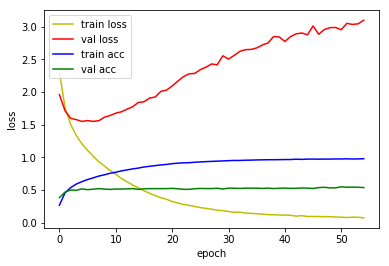

4815/4815 [==============================] - 2s 358us/sample - loss: 1.6197 - acc: 0.4868
Loss: 1.6197364272358261 Accuracy: 0.48681206

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3079 - acc: 0.2492
Epoch 00001: val_loss improved from inf to 1.80757, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_4_conv_checkpoint/001-1.8076.hdf5
36805/36805 [==============================] - 26s 715us/sample - loss: 2.3078 - acc: 0.2493 - val_loss: 1.8076 - val_acc: 0.4426
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7094 - acc: 0.4546
Epoch 00002: val_loss improved from 1.80757 to 1.57921, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_4_conv_checkpoint/002-1.5792.hdf5
36805/36805 [==============================] - 25s 681us/sample - loss: 1.7095 - acc: 0.4545 - val_loss: 1.5792 - val_acc: 0.4962
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3681 - acc: 0.8851
Epoch 00027: val_loss did not improve from 1.18464
36805/36805 [==============================] - 25s 672us/sample - loss: 0.3681 - acc: 0.8851 - val_loss: 1.3265 - val_acc: 0.6653
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3506 - acc: 0.8916
Epoch 00028: val_loss did not improve from 1.18464
36805/36805 [==============================] - 25s 671us/sample - loss: 0.3505 - acc: 0.8916 - val_loss: 1.4025 - val_acc: 0.6497
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3355 - acc: 0.8956
Epoch 00029: val_loss did not improve from 1.18464
36805/36805 [==============================] - 25s 678us/sample - loss: 0.3354 - acc: 0.8956 - val_loss: 1.3478 - val_acc: 0.6646
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3173 - acc: 0.9016
Epoch 00030: val_loss did not improve from 1.18464
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9615
Epoch 00057: val_loss did not improve from 1.18464
36805/36805 [==============================] - 25s 675us/sample - loss: 0.1277 - acc: 0.9616 - val_loss: 1.7512 - val_acc: 0.6799
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1311 - acc: 0.9607
Epoch 00058: val_loss did not improve from 1.18464
36805/36805 [==============================] - 25s 673us/sample - loss: 0.1311 - acc: 0.9607 - val_loss: 1.7773 - val_acc: 0.6720
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1267 - acc: 0.9627
Epoch 00059: val_loss did not improve from 1.18464
36805/36805 [==============================] - 25s 678us/sample - loss: 0.1267 - acc: 0.9627 - val_loss: 1.7541 - val_acc: 0.6762
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1237 - acc: 0.9625
Epoch 00060: val_loss did not improve from 1.18464
36805/36805 [=====

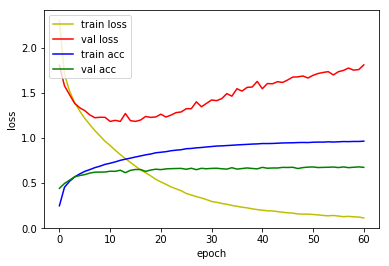

4815/4815 [==============================] - 2s 374us/sample - loss: 1.2622 - acc: 0.6037
Loss: 1.2621989315543962 Accuracy: 0.6037383

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2638 - acc: 0.2601
Epoch 00001: val_loss improved from inf to 1.73378, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_5_conv_checkpoint/001-1.7338.hdf5
36805/36805 [==============================] - 28s 763us/sample - loss: 2.2638 - acc: 0.2602 - val_loss: 1.7338 - val_acc: 0.4400
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6669 - acc: 0.4625
Epoch 00002: val_loss improved from 1.73378 to 1.48264, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_5_conv_checkpoint/002-1.4826.hdf5
36805/36805 [==============================] - 26s 699us/sample - loss: 1.6668 - acc: 0.4625 - val_loss: 1.4826 - val_acc: 0.5295
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4556 - acc: 0.8616
Epoch 00024: val_loss did not improve from 0.84781
36805/36805 [==============================] - 26s 699us/sample - loss: 0.4556 - acc: 0.8616 - val_loss: 0.8642 - val_acc: 0.7468
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4348 - acc: 0.8670
Epoch 00025: val_loss did not improve from 0.84781
36805/36805 [==============================] - 26s 700us/sample - loss: 0.4348 - acc: 0.8670 - val_loss: 0.9588 - val_acc: 0.7372
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4122 - acc: 0.8746
Epoch 00026: val_loss did not improve from 0.84781
36805/36805 [==============================] - 26s 700us/sample - loss: 0.4123 - acc: 0.8745 - val_loss: 0.9180 - val_acc: 0.7484
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3972 - acc: 0.8774
Epoch 00027: val_loss did not improve from 0.84781
36805/36805 [=====

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1389 - acc: 0.9568
Epoch 00054: val_loss did not improve from 0.84781
36805/36805 [==============================] - 26s 698us/sample - loss: 0.1388 - acc: 0.9568 - val_loss: 1.1573 - val_acc: 0.7598
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1426 - acc: 0.9545
Epoch 00055: val_loss did not improve from 0.84781
36805/36805 [==============================] - 26s 701us/sample - loss: 0.1426 - acc: 0.9545 - val_loss: 1.1396 - val_acc: 0.7589
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1354 - acc: 0.9581
Epoch 00056: val_loss did not improve from 0.84781
36805/36805 [==============================] - 26s 700us/sample - loss: 0.1355 - acc: 0.9580 - val_loss: 1.1791 - val_acc: 0.7575
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9598
Epoch 00057: val_loss did not improve from 0.84781
36805/36805 [=====

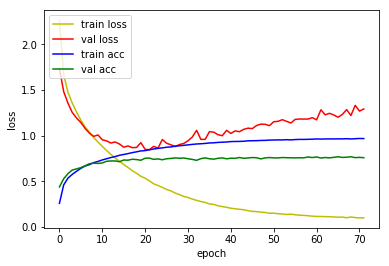

4815/4815 [==============================] - 2s 390us/sample - loss: 0.9731 - acc: 0.7128
Loss: 0.9731363266056572 Accuracy: 0.7127726

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3417 - acc: 0.2350
Epoch 00001: val_loss improved from inf to 1.79170, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_6_conv_checkpoint/001-1.7917.hdf5
36805/36805 [==============================] - 30s 807us/sample - loss: 2.3407 - acc: 0.2353 - val_loss: 1.7917 - val_acc: 0.4414
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6884 - acc: 0.4565
Epoch 00002: val_loss improved from 1.79170 to 1.47713, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_6_conv_checkpoint/002-1.4771.hdf5
36805/36805 [==============================] - 26s 712us/sample - loss: 1.6883 - acc: 0.4565 - val_loss: 1.4771 - val_acc: 0.5416
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5086 - acc: 0.8463
Epoch 00023: val_loss improved from 0.55860 to 0.53373, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_6_conv_checkpoint/023-0.5337.hdf5
36805/36805 [==============================] - 26s 708us/sample - loss: 0.5085 - acc: 0.8464 - val_loss: 0.5337 - val_acc: 0.8463
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4931 - acc: 0.8494
Epoch 00024: val_loss did not improve from 0.53373
36805/36805 [==============================] - 26s 704us/sample - loss: 0.4930 - acc: 0.8494 - val_loss: 0.5414 - val_acc: 0.8416
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4741 - acc: 0.8585
Epoch 00025: val_loss improved from 0.53373 to 0.52424, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_6_conv_checkpoint/025-0.5242.hdf5
36805/36805 [==============================] - 26s 706us/sample - loss: 0.4741 - acc: 0.8585

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2591 - acc: 0.9183
Epoch 00048: val_loss did not improve from 0.44084
36805/36805 [==============================] - 26s 712us/sample - loss: 0.2592 - acc: 0.9183 - val_loss: 0.4668 - val_acc: 0.8814
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2574 - acc: 0.9204
Epoch 00049: val_loss did not improve from 0.44084
36805/36805 [==============================] - 26s 706us/sample - loss: 0.2574 - acc: 0.9204 - val_loss: 0.4466 - val_acc: 0.8854
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2433 - acc: 0.9246
Epoch 00050: val_loss did not improve from 0.44084
36805/36805 [==============================] - 26s 710us/sample - loss: 0.2433 - acc: 0.9246 - val_loss: 0.4443 - val_acc: 0.8919
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2373 - acc: 0.9258
Epoch 00051: val_loss improved from 0.44084 to 0.43660, saving model 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1520 - acc: 0.9501
Epoch 00077: val_loss did not improve from 0.43660
36805/36805 [==============================] - 26s 707us/sample - loss: 0.1520 - acc: 0.9501 - val_loss: 0.4799 - val_acc: 0.8952
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9543
Epoch 00078: val_loss did not improve from 0.43660
36805/36805 [==============================] - 26s 704us/sample - loss: 0.1424 - acc: 0.9544 - val_loss: 0.4821 - val_acc: 0.8949
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1443 - acc: 0.9533
Epoch 00079: val_loss did not improve from 0.43660
36805/36805 [==============================] - 26s 704us/sample - loss: 0.1444 - acc: 0.9533 - val_loss: 0.5147 - val_acc: 0.8877
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9518
Epoch 00080: val_loss did not improve from 0.43660
36805/36805 [==================

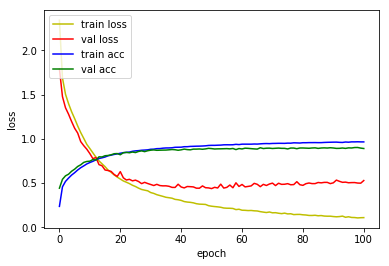

4815/4815 [==============================] - 2s 432us/sample - loss: 0.5331 - acc: 0.8534
Loss: 0.5330665096563219 Accuracy: 0.8533749

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4974 - acc: 0.1771
Epoch 00001: val_loss improved from inf to 1.96736, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_7_conv_checkpoint/001-1.9674.hdf5
36805/36805 [==============================] - 31s 850us/sample - loss: 2.4973 - acc: 0.1771 - val_loss: 1.9674 - val_acc: 0.3778
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.8140 - acc: 0.4070
Epoch 00002: val_loss improved from 1.96736 to 1.50831, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_7_conv_checkpoint/002-1.5083.hdf5
36805/36805 [==============================] - 27s 736us/sample - loss: 1.8136 - acc: 0.4071 - val_loss: 1.5083 - val_acc: 0.5376
Epoch 3/500
36736/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4118 - acc: 0.8739
Epoch 00023: val_loss improved from 0.38271 to 0.35739, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_7_conv_checkpoint/023-0.3574.hdf5
36805/36805 [==============================] - 27s 733us/sample - loss: 0.4118 - acc: 0.8738 - val_loss: 0.3574 - val_acc: 0.8977
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4005 - acc: 0.8760
Epoch 00024: val_loss improved from 0.35739 to 0.35142, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_7_conv_checkpoint/024-0.3514.hdf5
36805/36805 [==============================] - 27s 734us/sample - loss: 0.4003 - acc: 0.8760 - val_loss: 0.3514 - val_acc: 0.9026
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3862 - acc: 0.8797
Epoch 00025: val_loss did not improve from 0.35142
36805/36805 [==============================] - 27s 726us/sample - loss: 0.3860 - acc: 0.8798

Epoch 49/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2216 - acc: 0.9296
Epoch 00049: val_loss did not improve from 0.25809
36805/36805 [==============================] - 27s 735us/sample - loss: 0.2216 - acc: 0.9295 - val_loss: 0.2845 - val_acc: 0.9189
Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2204 - acc: 0.9277
Epoch 00050: val_loss improved from 0.25809 to 0.24800, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_7_conv_checkpoint/050-0.2480.hdf5
36805/36805 [==============================] - 27s 735us/sample - loss: 0.2206 - acc: 0.9277 - val_loss: 0.2480 - val_acc: 0.9317
Epoch 51/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2141 - acc: 0.9315
Epoch 00051: val_loss improved from 0.24800 to 0.24126, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_7_conv_checkpoint/051-0.2413.hdf5
36805/36805 [==============================] - 27s 738us/sample - loss: 0.2141 - acc: 0.9315

36800/36805 [============================>.] - ETA: 0s - loss: 0.1524 - acc: 0.9498
Epoch 00076: val_loss did not improve from 0.22829
36805/36805 [==============================] - 27s 740us/sample - loss: 0.1524 - acc: 0.9498 - val_loss: 0.2362 - val_acc: 0.9383
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1531 - acc: 0.9498
Epoch 00077: val_loss did not improve from 0.22829
36805/36805 [==============================] - 27s 736us/sample - loss: 0.1531 - acc: 0.9498 - val_loss: 0.2448 - val_acc: 0.9387
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1509 - acc: 0.9507
Epoch 00078: val_loss did not improve from 0.22829
36805/36805 [==============================] - 27s 736us/sample - loss: 0.1509 - acc: 0.9507 - val_loss: 0.2406 - val_acc: 0.9397
Epoch 79/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1507 - acc: 0.9506
Epoch 00079: val_loss did not improve from 0.22829
36805/36805 [==================

36736/36805 [============================>.] - ETA: 0s - loss: 0.1092 - acc: 0.9636
Epoch 00105: val_loss did not improve from 0.22453
36805/36805 [==============================] - 27s 733us/sample - loss: 0.1091 - acc: 0.9637 - val_loss: 0.2416 - val_acc: 0.9441
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1081 - acc: 0.9626
Epoch 00106: val_loss did not improve from 0.22453
36805/36805 [==============================] - 27s 731us/sample - loss: 0.1081 - acc: 0.9626 - val_loss: 0.2712 - val_acc: 0.9357
Epoch 107/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1109 - acc: 0.9636
Epoch 00107: val_loss did not improve from 0.22453
36805/36805 [==============================] - 27s 727us/sample - loss: 0.1108 - acc: 0.9636 - val_loss: 0.2375 - val_acc: 0.9448
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9635
Epoch 00108: val_loss did not improve from 0.22453
36805/36805 [===============

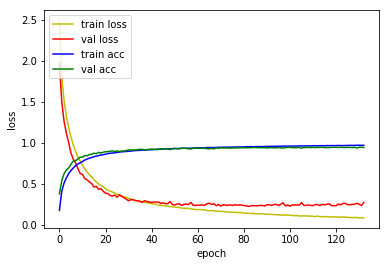

4815/4815 [==============================] - 2s 414us/sample - loss: 0.2795 - acc: 0.9229
Loss: 0.2795416520763409 Accuracy: 0.92294914

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4347 - acc: 0.2014
Epoch 00001: val_loss improved from inf to 1.81125, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_8_conv_checkpoint/001-1.8112.hdf5
36805/36805 [==============================] - 33s 886us/sample - loss: 2.4348 - acc: 0.2015 - val_loss: 1.8112 - val_acc: 0.4326
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6887 - acc: 0.4415
Epoch 00002: val_loss improved from 1.81125 to 1.32143, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_8_conv_checkpoint/002-1.3214.hdf5
36805/36805 [==============================] - 28s 757us/sample - loss: 1.6887 - acc: 0.4415 - val_loss: 1.3214 - val_acc: 0.5893
Epoch 3/500
36736/36805 [============================>.] - E

36736/36805 [============================>.] - ETA: 0s - loss: 0.3742 - acc: 0.8810
Epoch 00023: val_loss improved from 0.32149 to 0.30284, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_8_conv_checkpoint/023-0.3028.hdf5
36805/36805 [==============================] - 28s 750us/sample - loss: 0.3741 - acc: 0.8810 - val_loss: 0.3028 - val_acc: 0.9057
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3619 - acc: 0.8833
Epoch 00024: val_loss did not improve from 0.30284
36805/36805 [==============================] - 28s 755us/sample - loss: 0.3619 - acc: 0.8833 - val_loss: 0.3383 - val_acc: 0.8975
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3509 - acc: 0.8858
Epoch 00025: val_loss improved from 0.30284 to 0.27652, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_8_conv_checkpoint/025-0.2765.hdf5
36805/36805 [==============================] - 28s 755us/sample - loss: 0.3509 - acc: 0.8858 - val_loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1853 - acc: 0.9395
Epoch 00047: val_loss improved from 0.17814 to 0.17283, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_8_conv_checkpoint/047-0.1728.hdf5
36805/36805 [==============================] - 28s 755us/sample - loss: 0.1853 - acc: 0.9395 - val_loss: 0.1728 - val_acc: 0.9522
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1758 - acc: 0.9423
Epoch 00048: val_loss did not improve from 0.17283
36805/36805 [==============================] - 28s 756us/sample - loss: 0.1758 - acc: 0.9423 - val_loss: 0.1859 - val_acc: 0.9467
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1737 - acc: 0.9431
Epoch 00049: val_loss did not improve from 0.17283
36805/36805 [==============================] - 28s 747us/sample - loss: 0.1737 - acc: 0.9431 - val_loss: 0.2135 - val_acc: 0.9364
Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0

36736/36805 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9615
Epoch 00073: val_loss improved from 0.15275 to 0.15175, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_8_conv_checkpoint/073-0.1517.hdf5
36805/36805 [==============================] - 28s 754us/sample - loss: 0.1158 - acc: 0.9615 - val_loss: 0.1517 - val_acc: 0.9576
Epoch 74/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1134 - acc: 0.9609
Epoch 00074: val_loss did not improve from 0.15175
36805/36805 [==============================] - 28s 758us/sample - loss: 0.1135 - acc: 0.9609 - val_loss: 0.1532 - val_acc: 0.9550
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9618
Epoch 00075: val_loss did not improve from 0.15175
36805/36805 [==============================] - 28s 755us/sample - loss: 0.1110 - acc: 0.9618 - val_loss: 0.1559 - val_acc: 0.9532
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 102/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0766 - acc: 0.9731
Epoch 00102: val_loss did not improve from 0.15047
36805/36805 [==============================] - 28s 749us/sample - loss: 0.0766 - acc: 0.9731 - val_loss: 0.1687 - val_acc: 0.9574
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0746 - acc: 0.9740
Epoch 00103: val_loss did not improve from 0.15047
36805/36805 [==============================] - 27s 743us/sample - loss: 0.0746 - acc: 0.9741 - val_loss: 0.1789 - val_acc: 0.9557
Epoch 104/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9729
Epoch 00104: val_loss did not improve from 0.15047
36805/36805 [==============================] - 28s 748us/sample - loss: 0.0787 - acc: 0.9729 - val_loss: 0.1848 - val_acc: 0.9543
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0708 - acc: 0.9754
Epoch 00105: val_loss did not improve from 0.15047
36805/36805 [=

Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9805
Epoch 00132: val_loss did not improve from 0.15047
36805/36805 [==============================] - 27s 745us/sample - loss: 0.0568 - acc: 0.9805 - val_loss: 0.1707 - val_acc: 0.9576
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9800
Epoch 00133: val_loss did not improve from 0.15047
36805/36805 [==============================] - 27s 739us/sample - loss: 0.0543 - acc: 0.9800 - val_loss: 0.1934 - val_acc: 0.9553
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9820
Epoch 00134: val_loss did not improve from 0.15047
36805/36805 [==============================] - 27s 745us/sample - loss: 0.0519 - acc: 0.9820 - val_loss: 0.1719 - val_acc: 0.9588
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9818
Epoch 00135: val_loss did not improve from 0.15047
36805/36805 [=

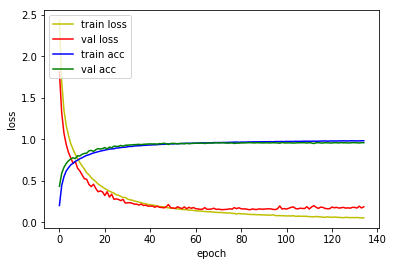

4815/4815 [==============================] - 2s 421us/sample - loss: 0.2012 - acc: 0.9425
Loss: 0.2011764725838495 Accuracy: 0.94247144

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2546 - acc: 0.2699
Epoch 00001: val_loss improved from inf to 1.49354, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_9_conv_checkpoint/001-1.4935.hdf5
36805/36805 [==============================] - 34s 934us/sample - loss: 2.2544 - acc: 0.2700 - val_loss: 1.4935 - val_acc: 0.5278
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3655 - acc: 0.5575
Epoch 00002: val_loss improved from 1.49354 to 1.00251, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_9_conv_checkpoint/002-1.0025.hdf5
36805/36805 [==============================] - 28s 767us/sample - loss: 1.3655 - acc: 0.5575 - val_loss: 1.0025 - val_acc: 0.6858
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2199 - acc: 0.9288
Epoch 00023: val_loss did not improve from 0.19656
36805/36805 [==============================] - 28s 765us/sample - loss: 0.2198 - acc: 0.9288 - val_loss: 0.1974 - val_acc: 0.9369
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2119 - acc: 0.9307
Epoch 00024: val_loss improved from 0.19656 to 0.18122, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_9_conv_checkpoint/024-0.1812.hdf5
36805/36805 [==============================] - 28s 772us/sample - loss: 0.2118 - acc: 0.9308 - val_loss: 0.1812 - val_acc: 0.9411
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2021 - acc: 0.9339
Epoch 00025: val_loss did not improve from 0.18122
36805/36805 [==============================] - 28s 770us/sample - loss: 0.2022 - acc: 0.9338 - val_loss: 0.1938 - val_acc: 0.9415
Epoch 26/500
36800/36805 [============================>.] - ETA:

36736/36805 [============================>.] - ETA: 0s - loss: 0.0862 - acc: 0.9703
Epoch 00050: val_loss did not improve from 0.15988
36805/36805 [==============================] - 28s 763us/sample - loss: 0.0863 - acc: 0.9702 - val_loss: 0.1726 - val_acc: 0.9527
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9704
Epoch 00051: val_loss did not improve from 0.15988
36805/36805 [==============================] - 28s 766us/sample - loss: 0.0854 - acc: 0.9704 - val_loss: 0.1610 - val_acc: 0.9546
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9696
Epoch 00052: val_loss did not improve from 0.15988
36805/36805 [==============================] - 28s 766us/sample - loss: 0.0894 - acc: 0.9697 - val_loss: 0.1771 - val_acc: 0.9518
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0800 - acc: 0.9728
Epoch 00053: val_loss did not improve from 0.15988
36805/36805 [==================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9854
Epoch 00080: val_loss did not improve from 0.15988
36805/36805 [==============================] - 28s 774us/sample - loss: 0.0434 - acc: 0.9854 - val_loss: 0.2200 - val_acc: 0.9492
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9837
Epoch 00081: val_loss did not improve from 0.15988
36805/36805 [==============================] - 28s 770us/sample - loss: 0.0470 - acc: 0.9837 - val_loss: 0.2114 - val_acc: 0.9560
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9848
Epoch 00082: val_loss did not improve from 0.15988
36805/36805 [==============================] - 28s 766us/sample - loss: 0.0456 - acc: 0.9848 - val_loss: 0.2168 - val_acc: 0.9513
Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9849
Epoch 00083: val_loss did not improve from 0.15988
36805/36805 [=====

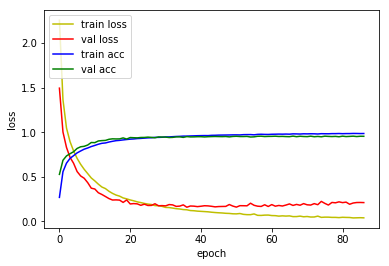

4815/4815 [==============================] - 2s 463us/sample - loss: 0.2478 - acc: 0.9267
Loss: 0.24777987390168607 Accuracy: 0.9266874



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO_025_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_025_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_32_DO_025_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_44 (Activation)   (No

4815/4815 [==============================] - 2s 432us/sample - loss: 0.5331 - acc: 0.8534
Loss: 0.5330665096563219 Accuracy: 0.8533749

1D_CNN_custom_ch_32_DO_025_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           

4815/4815 [==============================] - 2s 513us/sample - loss: 0.2478 - acc: 0.9267
Loss: 0.24777987390168607 Accuracy: 0.9266874


In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_32_DO_025_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_44 (Activation)   (No

4815/4815 [==============================] - 3s 535us/sample - loss: 0.6166 - acc: 0.8650
Loss: 0.6165878357669399 Accuracy: 0.8650052

1D_CNN_custom_ch_32_DO_025_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           

4815/4815 [==============================] - 3s 561us/sample - loss: 0.2987 - acc: 0.9362
Loss: 0.29866755732858835 Accuracy: 0.9362409
